In [ ]:
#this part is actually reduntant used the freeing up the directory in which data will be stored , no need to run it if data is already there
#from os import listdir , remove
#from os.path import isfile, join
#mypath = '/content/drive/My Drive'
#onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#for i in onlyfiles:
#  remove(str(i))     

In [ ]:
#global imports
import os
import PIL
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

In [ ]:
#loading and precoesing the csv which contains training data
import pandas as pd
csv_url = "https://raw.githubusercontent.com/subashgandyer/Myntra-Tshirt-Classification/master/vidai8_new.csv"
document = pd.read_csv(csv_url , error_bad_lines=False) 
document.head()

,Brand,Category,Gender,Color,Link_to_the_image,Sub_category
0,Allen Solly,Tshirts,Men,Red,http://myntra.myntassets.com/assets/images/182...,Solid
1,Celio,Tshirts,Men,Yellow,http://myntra.myntassets.com/assets/images/109...,Solid
2,CULT FICTION,Tshirts,Men,Rust,http://myntra.myntassets.com/assets/images/159...,Solid
3,Antigravity,Tshirts,Women,Blue,http://myntra.myntassets.com/assets/images/185...,Conversational
4,Being Human,Tshirts,Men,Charcoal,http://myntra.myntassets.com/assets/images/100...,Sports and Team Jersey


In [ ]:
class_names = np.unique(document['Sub_category'])
class_names
num_classes = len(class_names)
num_classes

23

In [ ]:
#to decode a jpg image to RGB channel
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
#display an image
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

2.3.0
The following GPU devices are available: 


In [ ]:
#to download and resize an image from an url
def download_and_resize_image(url, tag , id ,  new_width=224, new_height=224,
                              display=False):
  try:
    parent_dir = '/content/drive/My Drive/Diana/data/'
    foldername = parent_dir + tag
    try:
      os.mkdir(foldername)   
    except OSError as error: 
      pass
    filename = parent_dir + tag + '/tshirt_' + str(id) + '_' + tag + '.jpg'
    print(filename)
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
      display_image(pil_image)
    return filename
  except:
    pass  

In [ ]:
#to download and split the training and validation data
for i in range(len(document['Link_to_the_image'])):
  image_url , tag , color = document['Link_to_the_image'][i] , document['Sub_category'][i] , document['Color'][i]
  download_and_resize_image(str(image_url) , str(tag) , i ,224, 224,display=False)

  

In [ ]:
root_dir = pathlib.Path('Diana')
root_dir

PosixPath('Diana')

In [ ]:
#get the total count of images downloaded and initialize project directory and data_dir
data_dir = '/content/drive/My Drive/Diana/data/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)



13036


In [ ]:
#self-explanatory contants
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
#preparing training and validation data with high-level keras api 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 13036 files belonging to 23 classes.
Using 10429 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 13036 files belonging to 23 classes.
Using 2607 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)


['Abstract', 'Biker', 'Camouflage', 'Checked', 'Colourblocked', 'Conversational', 'Floral', 'Geometric', 'Graphic', 'Humour and Comic', 'Music', 'People and Places', 'Polka Dots', 'Self Design', 'Solid', 'Sports', 'Sports and Team Jersey', 'Striped', 'Superhero', 'Tie and Dye', 'Tribal', 'Typography', 'Varsity']


In [ ]:
#converting image to input tensors 
IMAGE_SHAPE = (224, 224)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_dir), target_size=IMAGE_SHAPE)


Found 13036 images belonging to 23 classes.


In [ ]:
#separating image batch and label_batch from image_data
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 23)


In [ ]:
#mobilet classifier to download the classifier
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 


In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])


In [ ]:
result_batch = classifier.predict(image_batch)
result_batch.shape


(32, 1001)

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


16384/10484 [==============================================] - 0s 0us/step


In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names


array(['jersey', 'jersey', 'jersey', 'jersey', 'sweatshirt', 'sweatshirt',
       'cuirass', 'jersey', 'jersey', 'jersey', 'jersey', 'jersey',
       'jersey', 'jersey', 'jersey', 'cardigan', 'jersey', 'jersey',
       'jersey', 'maillot', 'jersey', 'jersey', 'lab coat', 'jersey',
       'jersey', 'jersey', 'jersey', 'maillot', 'jersey', 'jersey',
       'jersey', 'jersey'], dtype='<U30')

In [ ]:
#headless mobilener classifier url
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 


In [ ]:
#download mobilenet classifier
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))


In [ ]:
#extracting the feature batch
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)


(32, 1280)


In [ ]:
#fixing all the bottom layers upto the bottleneck Flatten() layer
feature_extractor_layer.trainable = False


In [ ]:
#add a top layer and check the model summary
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 23)                29463     
Total params: 2,287,447
Trainable params: 29,463
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)


In [ ]:
predictions.shape


TensorShape([32, 23])

In [ ]:
#compile model with 'adam' optimizer and accuracy matrices
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()


In [ ]:
#model training with newly added layers
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])


Epoch 1/5
408/408 [==============================] - 473s 1s/step - loss: 0.9643 - acc: 0.6875
Epoch 2/5
408/408 [==============================] - 471s 1s/step - loss: 0.9702 - acc: 0.6562
Epoch 3/5
408/408 [==============================] - 469s 1s/step - loss: 1.2209 - acc: 0.5938
Epoch 4/5
408/408 [==============================] - 474s 1s/step - loss: 0.6842 - acc: 0.8125
Epoch 5/5
408/408 [==============================] - 466s 1s/step - loss: 0.6502 - acc: 0.7812


In [ ]:
model.summary() #new model summary

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 23)                29463     
Total params: 2,287,447
Trainable params: 29,463
Non-trainable params: 2,257,984
_________________________________________________________________


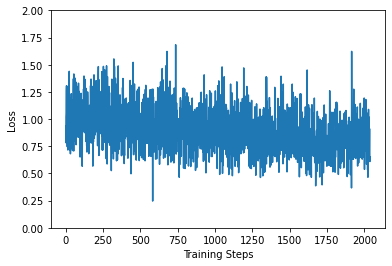

In [ ]:
#plot the loss graph as the training progresses
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)


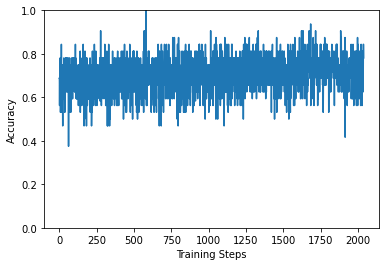

In [ ]:
#plot the accuracy graph as the training progresses
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)


In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names
#checkout the classnames

array(['Abstract', 'Biker', 'Camouflage', 'Checked', 'Colourblocked',
       'Conversational', 'Floral', 'Geometric', 'Graphic',
       'Humour And Comic', 'Music', 'People And Places', 'Polka Dots',
       'Self Design', 'Solid', 'Sports', 'Sports And Team Jersey',
       'Striped', 'Superhero', 'Tie And Dye', 'Tribal', 'Typography',
       'Varsity'], dtype='<U22')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
#image and label batch

In [ ]:
label_id = np.argmax(label_batch, axis=-1)


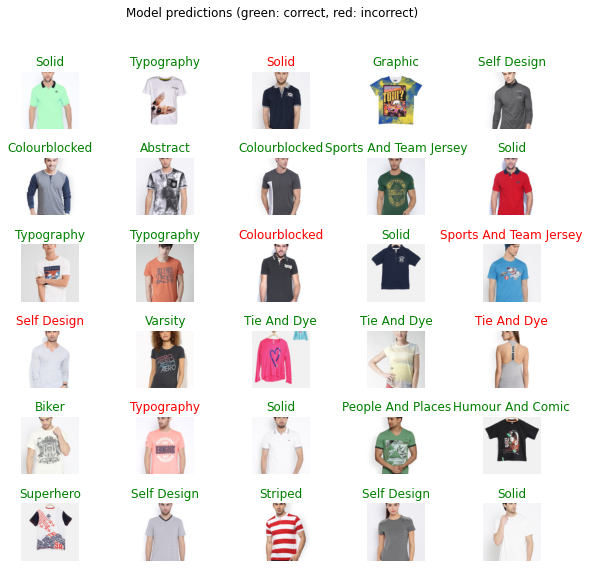

In [ ]:
#visually validate how well the model predictions are
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")


49152/43401 [=================================] - 0s 0us/step


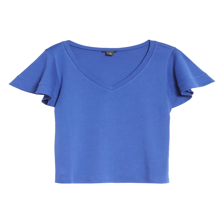

In [ ]:
grace_hopper = tf.keras.utils.get_file('/tmp/image.jpg','https://n.nordstrommedia.com/id/sr3/6c18b57a-a99e-4b4c-8311-ab87b254a19b.jpeg?crop=pad&pad_color=FFF&format=jpeg&w=780&h=1196')
grace_hopper = Image.open(grace_hopper).resize((224,224))
grace_hopper
#check for a single image_prediction 

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape
#input shape

(224, 224, 3)

In [ ]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape
#shape of result 

(1, 23)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class
#check the output 

4

In [ ]:
class_names[predicted_class]
#map the output with original class_names

'Colourblocked'

In [ ]:
root_dir = 'Diana'
list_ds = tf.data.Dataset.list_files(str(root_dir)+'/*')
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)


In [ ]:
list_ds

<ShuffleDataset shapes: (), types: tf.string>

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())


b'Diana/tshirt_11772_Solid.jpg'
b'Diana/tshirt_10382_Graphic.jpg'
b'Diana/tshirt_11886_Solid.jpg'
b'Diana/tshirt_9060_Varsity.jpg'
b'Diana/tshirt_5688_Typography.jpg'


In [ ]:
image_count = len(list_ds)
print(image_count)

13037


In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  filename = parts[-1]
  #subcategory
  subcategory_array = tf.strings.split(filename, '_')
  subcategory_name = subcategory_array[-1]
  exclude_jpg = tf.strings.split(subcategory_name, '.')
  final_tag_string = exclude_jpg[0]  == class_names
  # Integer encode the label
  #return tf.argmax(one_hot)
  return tf.argmax(final_tag_string)


In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [224,224])


In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

TypeError: ignored

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


10430
2607


In [ ]:
get_label(b'Diana/tshirt_9642_Sports and Team Jersey.jpg'
b'Diana/tshirt_8323_Solid.jpg')

<tf.Tensor: shape=(), dtype=int64, numpy=14>

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = load_img(file_path)
  return img, label

In [ ]:
print(image_count)

13037


In [ ]:
def display_with_label(path):
  img , label = process_path(path)
  display_image(img)


In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path)
val_ds = val_ds.map(process_path)


TypeError: ignored

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


for imag, label in train_ds.take(2):
  imag = tf.image.resize(imag,[224,224])
  print("Image shape: ", imag.numpy().shape)
  print("Label: ", label.numpy())


In [ ]:
print(train_ds)

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.uint8, tf.int64)>


In [ ]:
image_path = 'Diana/tshirt_9930_Colourblocked.jpg'
display_image(load_img(image_path))
print(get_label(image_path))

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(200)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


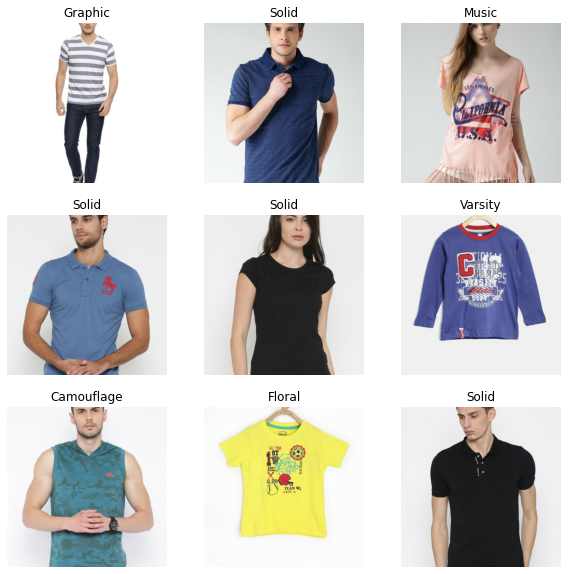

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


In [ ]:
file_path = 'Diana/tshirt_9642_Sports and Team Jersey.jpg';
img = tf.io.read_file(file_path)
img = tf.image.decode_jpeg(img, channels=3)

In [ ]:
display_with_label('Diana/tshirt_1749_Typography.jpg')

In [ ]:
!pip install -q tensorflow-hub
!pip install -q tensorflow-datasets
import tensorflow_hub as hub

from tensorflow.keras import layers


In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 


In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))


In [ ]:
image_batch = tf.image.resize(image_batch , [224,224])

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)


(200, 1280)


In [ ]:
feature_extractor_layer.trainable = False


In [ ]:
for image_batch, label_batch in train_ds:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break



In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(num_classes)
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 23)                29463     
Total params: 2,287,447
Trainable params: 29,463
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)


In [ ]:
predictions.shape


TensorShape([200, 23])

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()


In [ ]:
steps_per_epoch = 5

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])


Epoch 1/2


ValueError: ignored